# Anomaly Detection in Python

- https://github.com/abhishek-Kumar009/Machine-Learning/tree/master/AnomalyDetectionScratch
- https://gist.github.com/abhishek-Kumar009/6f3788a511a9694dca01f1b04af8b940
- https://towardsdatascience.com/wondering-how-to-build-an-anomaly-detection-model-87d28e50309

Anomaly detection is a technique used to identify unusual patterns that do not conform to expected behavior, called outliers. It has many applications in business, from intrusion detection (identifying strange patterns in network traffic that could signal a hack) to system health monitoring (spotting a malignant tumor in an MRI scan), and from fraud detection in credit card transactions to fault detection in operating environments.

In this article we will implement the anomaly detection algorithm and apply it to detect failing servers on a network.
Before going into the original dataset let's first visualize how to proceed and carry out different functions. Let's start by importing few libraries.

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import math
tic = time.time()

We'll be using a dummy dataset to check whether all the functions are working properly and we would then use these functions on our original dataset. Let's import the dataset.

In [2]:
dataset = sio.loadmat('anomalyData.mat')
X = dataset['X']
Xval = dataset['Xval']
yval = dataset['yval']

sio.loadmat() loads our dataset('anomalyData.mat') into the variable dataset. The variable 'X' contains the training dataset, 'Xval' the cross validation set and 'yval' the corresponding output for the 'Xval'. Let's see the array 'X' that we are going to use to fit it in a Gaussian model to detect anomalous examples.

In [3]:
print(X.shape)

(307, 2)


In [4]:
X.shape, Xval.shape, yval.shape

((307, 2), (307, 2), (307, 1))

As you can see there are 307 training examples and each having 2 features. The features measure the throughput (mb/s) and latency (ms) of response of each server. While your servers were operating, you collected m = 307 examples of how they were behaving,and thus have an unlabeled dataset {x(1), . . . , x(m)}. You suspect that the vast majority of these examples are “normal” (non-anomalous) examples of the servers operating normally, but there might also be some examples of servers acting anomalously within this dataset. Now, let's visualize the dataset to have a clear picture.

Text(0,0.5,'Throughput(mb/s)')

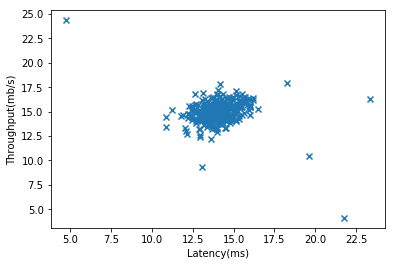

In [5]:
plt.scatter(X[:, 0], X[:, 1], marker = "x")
plt.xlabel('Latency(ms)')
plt.ylabel('Throughput(mb/s)')

# Gaussian distribution
To perform anomaly detection, you will first need to fit a model to the data’s distribution.
Given a training set {x(1), ..., x(m)} (where x(i) ∈ R^n, here n = 2), you want to estimate the Gaussian distribution for each of the features. For each feature (i = 1 . . . n), you need to find parameters mean and variance(mu, sigma^2). For doing that let's write down the function that calculates the mean and variance of the array(or you can call it matrix) X.

## Shawn's note
$
\begin{align}
\mu = \frac{\sum(x_i)}{n} \\
\sigma^2=E((X-\mu)^2)
\end{align}
$

In [6]:
def estimateGaussian(X):
    n = np.size(X, 1)
    m = np.size(X, 0)
    mu = np.zeros((n, 1))
    sigma2 = np.zeros((n, 1))
    
    mu = np.reshape((1/m)*np.sum(X, 0), (1, n))
    sigma2 = np.reshape((1/m)*np.sum(np.power((X - mu),2), 0),(1, n))
    
    return mu, sigma2

In [7]:
mu, sigma2 = estimateGaussian(X)

In [8]:
print('mean: ',mu,' variance: ',sigma2)

mean:  [[14.11222578 14.99771051]]  variance:  [[1.83263141 1.70974533]]


In [9]:
mu.shape

(1, 2)

In [10]:
sigma2.shape

(1, 2)

Now that we have the mean and variance let's find out the probabilities of the dataset by writing down the multivariate Gaussian function. But before that let's look at what actually the function does.

# Multivariate Gaussian Distribution
The multivariate gaussian is used to find the probabilities of each training example. It takes the mean(mu) and the co-variance matrix as it's parameters and returns the probabilities of the dataset passed. Let's see how to do that. 

In [11]:
sigma2[0, :]

array([1.83263141, 1.70974533])

In [12]:
np.diag(sigma2[0, :])

array([[1.83263141, 0.        ],
       [0.        , 1.70974533]])

In [13]:
math.pi

3.141592653589793

In [14]:
# ?np.linalg.det
"""Compute the determinant of an array"""
np.linalg.det(np.diag(sigma2[0, :]))

3.1333330023523955

In [15]:
# ?np.linalg.inv
"""Compute the (multiplicative) inverse of a matrix"""
np.linalg.inv(np.diag(sigma2[0, :]))

array([[0.54566346, 0.        ],
       [0.        , 0.58488243]])

In [16]:
def multivariateGaussian(X, mu, sigma2):
    """https://en.wikipedia.org/wiki/Multivariate_normal_distribution"""
    n = np.size(sigma2, 1)
    m = np.size(sigma2, 0)
    #print(m,n)

    if n == 1 or m == 1:        
        sigma2 = np.diag(sigma2[0, :])

    X = X - mu
    pi = math.pi
    det = np.linalg.det(sigma2)
    inv = np.linalg.inv(sigma2)
    val = np.reshape((-0.5)*np.sum(np.multiply((X@inv),X), 1),(np.size(X, 0), 1))

    """PDF"""
    p = np.power(2*pi, -n/2)*np.power(det, -0.5)*np.exp(val)

    return p

Inside the function first we convert the sigma2 vector into a covarince matrix and then we simply apply the formula for the multivariate distribution to get the probability vector.

In [17]:
p = multivariateGaussian(X, mu, sigma2)

p contains the proobabilities of the dataset.

In [18]:
print(p.shape)

(307, 1)


In an anomaly detection we use a threshold(epsilon) value of probability to determine whether an example is anomalous or not.

P > epsilon (negative or normal case),
P < epsilon (positive or anomalous case)

To determine this threshold value epsilon we need a cross-validation set which we already have collected from our anomalyFile above. Let's see how we go about doing this.

In [19]:
pval = multivariateGaussian(Xval, mu, sigma2)
pval[:5]

array([[0.04163207],
       [0.08190901],
       [0.04071578],
       [0.06190003],
       [0.07118676]])

In [20]:
pval.shape

(307, 1)

In [21]:
yval[:5]

array([[0],
       [0],
       [0],
       [0],
       [0]], dtype=uint8)

pval contains the probabilities for the cross-validation vector that we are gonna use to calculate threshold. Now, we are going to use this pval vector to calculate the threshold value. Precisely, we need a function that can analyze some labeled datasets and give us the threshold on the basis of some underlying theory. Let's see this function.


In [22]:
# ?np.arange
# (np.max(pval) - np.min(pval))/1000
# np.arange(np.min(pval), np.max(pval), (np.max(pval) - np.min(pval))/1000)
# len(np.arange(np.min(pval), np.max(pval), (np.max(pval) - np.min(pval))/1000))

In [23]:
def selectThreshHold(yval, pval):
    
    F1 = 0
    bestF1 = 0
    bestEpsilon = 0
    
    """Size of each step in 1000 steps"""
    stepsize = (np.max(pval) - np.min(pval))/1000

    """Return evenly spaced values within a given interval
    shape: (1000,)
    """
    epsVec = np.arange(np.min(pval), np.max(pval), stepsize)
    
    """1000 steps"""
    noe = len(epsVec)
    
    for eps in range(noe):
        epsilon = epsVec[eps]
        pred = (pval < epsilon)
        prec, rec = 0,0
        tp,fp,fn = 0,0,0
        
        try:
            for i in range(np.size(pval,0)):
                if pred[i] == 1 and yval[i] == 1:
                    tp+=1
                elif pred[i] == 1 and yval[i] == 0:
                    fp+=1
                elif pred[i] == 0 and yval[i] == 1:
                    fn+=1
            """precision"""
            prec = tp/(tp + fp)
            """recall"""
            rec = tp/(tp + fn)
            
            """https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/"""
            F1 = 2*prec*rec/(prec + rec)
            if F1 > bestF1:
                bestF1 = F1
                bestEpsilon = epsilon
        except ZeroDivisionError:
            print('Warning dividing by zero!!')          
       
    return bestF1, bestEpsilon

We'll implement F1-score principle to determine the best epsilon value. First, we use a variable called stepsize that takes a number of different epsilon values right from the minimum probability in pval to it's maximum. Then, we loop over all such values to find the optimum precision and recall. We are going to need a try except block because there can be cases where we divide by zero to calculate precision and recall. The epsilon value that gives the highest F1-score is taken as the best epsilon. The function returns the bestF1 and bestEpsilon.

In [24]:
F1, epsilon = selectThreshHold(yval, pval)
print('Epsilon and F1 are:',epsilon, F1)

Warning dividing by zero!!
Epsilon and F1 are: 8.990852779269493e-05 0.8750000000000001


To find out the outliers we need to check the examples whose probabilties are less than the threshold value epsilon.

In [25]:
outl = (p < epsilon)

We need to return the indices of the outliers to identify the faulty servers. This gives us a vector with binary entries where 1 means anomaly and 0 means normal.

In [26]:
def findIndices(binVec):
    l = []
    for i in range(len(binVec)):
        if binVec[i] == 1:
            l.append(i)
    return l

In [27]:
listOfOutliers = findIndices(outl)
count_outliers = len(listOfOutliers)
print('\n\nNumber of outliers:', count_outliers)
print('\n',listOfOutliers)



Number of outliers: 6

 [300, 301, 303, 304, 305, 306]


Thus, we have detected the faulty servers. One last thing in this dummy dataset is to visualize the anomalies graphically. Let's see how to plot them.

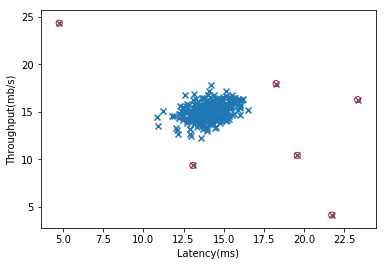

In [28]:
plt.scatter(X[:, 0], X[:, 1], marker = "x")
plt.xlabel('Latency(ms)')
plt.ylabel('Throughput(mb/s)')
plt.scatter(X[listOfOutliers,0], X[listOfOutliers, 1], facecolors = 'none', edgecolors = 'r')
plt.show()

The red circles shows the faulty servers in the network. Congratulations! you've successfully written down the code to work on some original and pretty large dataset.

Now, let's work this code out in some larger dataset.

In [29]:
newDataset = sio.loadmat('anomalyDataTest.mat')

Xtest = newDataset['X']
Xvaltest = newDataset['Xval']
yvaltest = newDataset['yval']

In [30]:
print(Xtest.shape)
print(Xvaltest.shape)
print(yvaltest.shape)

(1000, 11)
(100, 11)
(100, 1)


We'll repeat the same steps as above but simply on a larger dataset.

In [31]:
mutest, sigma2test = estimateGaussian(Xtest)

ptest = multivariateGaussian(Xtest, mutest, sigma2test)

pvaltest = multivariateGaussian(Xvaltest, mutest, sigma2test)

F1test, epsilontest = selectThreshHold(yvaltest, pvaltest)
print('\nBest epsilon and F1 are\n',epsilontest, F1test)

Warning dividing by zero!!

Best epsilon and F1 are
 1.3772288907613575e-18 0.6153846153846154


Now, we just need to check for the outliers

In [32]:
outliersTest = ptest < epsilontest
listOfOl = findIndices(outliersTest)

print('\n\n Outliers are:\n',listOfOl)
print('\n\nNumber of outliers are: ',len(listOfOl))



 Outliers are:
 [9, 20, 21, 30, 39, 56, 62, 63, 69, 70, 77, 79, 86, 103, 130, 147, 154, 166, 175, 176, 198, 209, 212, 218, 222, 227, 229, 233, 244, 262, 266, 271, 276, 284, 285, 288, 289, 290, 297, 303, 307, 308, 320, 324, 338, 341, 342, 344, 350, 351, 353, 365, 369, 371, 378, 398, 407, 420, 421, 424, 429, 438, 452, 455, 456, 462, 478, 497, 518, 527, 530, 539, 541, 551, 574, 583, 587, 602, 613, 614, 628, 648, 674, 678, 682, 685, 700, 702, 705, 713, 721, 741, 750, 757, 758, 787, 831, 834, 836, 839, 846, 870, 885, 887, 890, 901, 911, 930, 939, 940, 943, 951, 952, 970, 975, 992, 996]


Number of outliers are:  117
